In [4]:
import calendar
import math
from river import compose
from river import linear_model
from river import optim
from river import preprocessing
from river import time_series
from sklearn.model_selection import train_test_split
import pandas as pd
from river import neighbors

from river import metrics



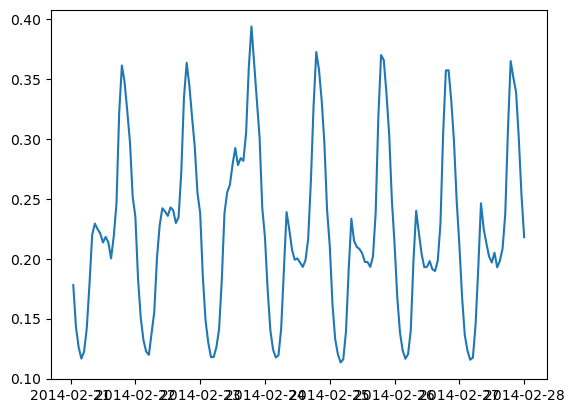

In [5]:

# Assuming df is your DataFrame and 'MeanEnergyConsumption' is your target variable
df = pd.read_csv('merged_data.csv')
df['DateTime'] = pd.to_datetime(df['DateTime'])

#take out a snipit of the data for testing that is one week long from the end of the data
test_data = df[df['DateTime'] > df['DateTime'].max() - pd.Timedelta(days=7)]




#get date range 
start_date = df["DateTime"].min()
end_date = df['DateTime'].max()

X = df.drop('MeanEnergyConsumption', axis=1)
y = df['MeanEnergyConsumption']

# Get month and day of the week from the date time column
X['Month'] = X['DateTime'].dt.month
X['DayOfWeek'] = X['DateTime'].dt.dayofweek



X_train = X
y_train = y

# Convert the training set back to DataFrame for the model training
train_df = pd.concat([X_train, y_train], axis=1)

#plot the data
import matplotlib.pyplot as plt
#plt.plot(train_df['DateTime'],train_df['MeanEnergyConsumption'])


#plot the last week of data
last_week = train_df[train_df['DateTime'] > end_date - pd.Timedelta(days=7)]
plt.plot(last_week['DateTime'],last_week['MeanEnergyConsumption'])


In [14]:
model_with_exog = (
    preprocessing.StandardScaler() |
    time_series.SNARIMAX(
        p=1,
        d=0,
        q=1,
        sp=0,
        sd=1,
        sq=1,
        m=24,
        regressor=(
            preprocessing.StandardScaler() |
            linear_model.LinearRegression(
                intercept_init=110,
                optimizer=optim.SGD(0.01),
                intercept_lr=0.3
            )
        )
    )
)

model_without_exog = (
    time_series.SNARIMAX(
        p=1,
        d=0,
        q=1,
        sp=0,
        sd=1,
        sq=1,
        m=24
    )
)


In [7]:
# Initialize the MAE metric
mae_with_exog = metrics.MAE()
mae_without_exog = metrics.MAE()

# Train the model without exogenous data
for i, (_, row) in enumerate(train_df.iterrows()):
    y = row['MeanEnergyConsumption']
    model_without_exog.learn_one(y)
    if i > 0:  # Skip the first observation
        forecast = model_without_exog.forecast(horizon=1)  # forecast 1 step ahead
        mae_without_exog.update(y, forecast[0])

print(f"One-step-ahead MAE without exogenous data: {mae_without_exog.get()}")

# Train the model with exogenous data
for i, (_, row) in enumerate(train_df.iterrows()):
    y = row['MeanEnergyConsumption']
    exog = row.drop('MeanEnergyConsumption').drop('DateTime').to_dict()
    model_with_exog.learn_one(exog, y)
    if i > 0:  # Skip the first observation
        forecast = model_with_exog.forecast(horizon=1, xs=[exog])  # forecast 1 step ahead
        mae_with_exog.update(y, forecast[0])

print(f"One-step-ahead MAE with exogenous data: {mae_with_exog.get()}")

One-step-ahead MAE without exogenous data: 0.02196715073869844
One-step-ahead MAE with exogenous data: 147769610053162.2


One-step-ahead MAE without exogenous data: 0.021605934223709836


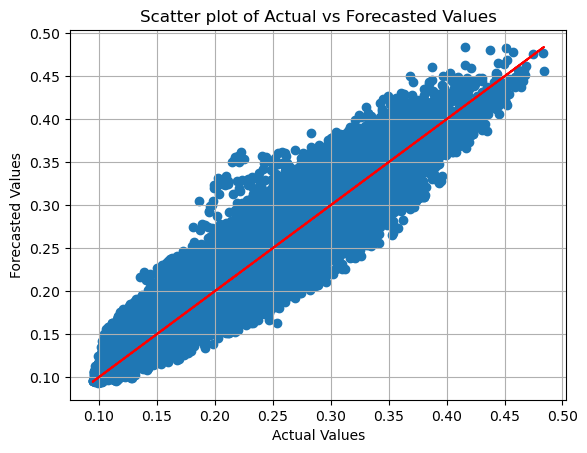

In [15]:
import matplotlib.pyplot as plt

# Initialize the MAE metric and lists to store actual and forecasted values
mae_without_exog = metrics.MAE()
actuals = []
forecasts = []

# Train the model without exogenous data
for i, (_, row) in enumerate(train_df.iterrows()):
    y = row['MeanEnergyConsumption']
    model_without_exog.learn_one(y)
    if i > 100:  # Skip the first observation
        forecast = model_without_exog.forecast(horizon=24*7)  # forecast 1 step ahead
        mae_without_exog.update(y, forecast[24*7-1])
        actuals.append(y)
        forecasts.append(forecast[24*7-1])

print(f"One-step-ahead MAE without exogenous data: {mae_without_exog.get()}")

# Create scatter plot
plt.scatter(actuals, forecasts)
plt.xlabel('Actual Values')
plt.ylabel('Forecasted Values')
plt.title('Scatter plot of Actual vs Forecasted Values')

# Add grid
plt.grid(True)

# Add red line for perfect predictions
plt.plot(actuals, actuals, 'r')

plt.show()